# Histogram Gradient Boosting Classifier

In [ ]:
# Imports
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import numpy as np
import time

## Loading in Data

The following code chunk uses polars to load in the training dataset. It then splits the data into X (features) and y (labels) numpy arrays. LabelEncoder is then used to convert the string labels into integers for model training. The shape of the resulting arrays is printed, along with the classes and their corresponding integer labels.

In [ ]:
# Loading in training data
data = pl.read_parquet('../data/training_data.parquet')

# Splitting features and labels
X = data.drop("label").to_numpy()
y = data["label"].to_numpy()

# Encoding labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Displaying shapes and encoder mapping
print(f"Features shape: {X.shape}, Labels shape: {y_encoded.shape}\n")
print("Classes:")
for i, class_label in enumerate(encoder.classes_):
    print(f"{i} -> {class_label}")

Features shape: (68250, 785), Labels shape: (68250,)

Classes:
0 -> airplane
1 -> ice cream
2 -> spreadsheet
3 -> sword


## Training the Model

The following code chunk uses the HistGradientBoostingClassifier class from sklearn to train a histogram-based gradient boosting model on the training data. Sklearn's Pipeline is used to create a pipeline that includes the classifier, along with KFold and GridSearchCV for cross-validation and hyperparameter tuning. The model is trained on the training data, and the time taken for training is printed.


**Note: No preprocessing needed inside pipeline. Feature scaling was performed globally on the dataset before being loaded. All image pixel values were normalized from the range `[0, 255]` to `[0, 1]` by dividing by `255`**

In [10]:
# Histogram-Based Gradient Boosting Classifier Pipeline

# Steps for the pipeline (No preprocessing needed inside pipeline. Data is images, so scaling was done uniformly beforehand)
steps = [
    ('hgb', HistGradientBoostingClassifier(max_iter = 100, random_state = 42))
]

# Creating the pipeline
hgb_pipeline = Pipeline(steps)

# Defining inner cross-validation object
inner_cv = KFold(n_splits = 4, random_state = 42, shuffle = True)

# Defining parameter grid for GridSearchCV
param_grid = {
    'hgb__learning_rate': [0.01, 0.1, 0.2],
    'hgb__max_depth': [3, 5, 7],
}

# Setting up GridSearchCV for Histogram-Based Gradient Boosting Classifier
hgb_grid = GridSearchCV(
    estimator = hgb_pipeline,
    param_grid = param_grid,
    scoring = 'accuracy',
    cv = inner_cv,
    n_jobs = 6,
    verbose = 1
)

# Fitting the model and timing the time to fit
hgb_start = time.time()
hgb_grid.fit(X, y_encoded)
hgb_end = time.time()
hgb_diff = hgb_end - hgb_start

# Printing at completion of training
print("Gradient Boosting Training Complete")
print(f"Time to train Gradient Boosting Model: {np.round(hgb_diff, 2)} seconds")

Fitting 4 folds for each of 9 candidates, totalling 36 fits


Gradient Boosting Training Complete
Time to train Gradient Boosting Model: 521.75 seconds


## Evaluating the Model

The following code chunks retrieve the best hyperparameters found from the grid search and the cross-validation accuracy of the best model, and use the best model to predict on the training set and plot a confusion matrix.

In [11]:
# Retrieve and print the best model hyperparameters
best_params = hgb_grid.best_params_
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'hgb__learning_rate': 0.1, 'hgb__max_depth': 7}


In [14]:
# Retrieve the cross-validation accuracy
cv_accuracy = hgb_grid.best_score_
print(f"Best Cross-Validation Accuracy: {cv_accuracy:.4f}")

Best Cross-Validation Accuracy: 0.9542


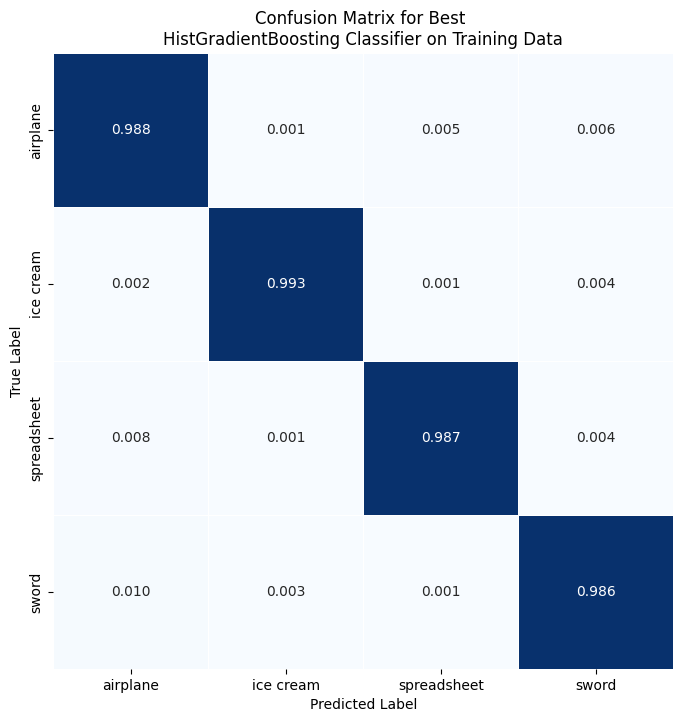

In [ ]:
# Use the best model to predict on the training set
best_model = hgb_grid.best_estimator_
y_pred = best_model.predict(X)

# Create a confusion matrix using the best model's predictions
    # Normalized due to non-uniform distribution of classes
cm = confusion_matrix(y_encoded, y_pred, normalize = 'true')


# Initialize figure
plt.figure(figsize=(8, 8))

# Plot confusion matrix
sns.heatmap(
    cm,
    annot=True,
    fmt='.3f',
    cmap='Blues',
    linewidths=.5,
    cbar=False,
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_
)
plt.title('Confusion Matrix for Best \nHistGradientBoosting Classifier on Training Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("../output/HGB_training_ConfusionMatrix.png")
plt.show()